# Tutorial – Privacidade em Vozes Sintéticas (Python Brasil) – Colab

Este notebook reúne **setup + EDA + baselines + provas de privacidade** usando o dataset
`Shahzaib-Arshad/audio-fake-real-dataset` (Hugging Face).

> **Observações importantes**
> - Selecione *Runtime* → *Change runtime type* → **GPU** (opcional, acelera os embeddings).
> - Este dataset é público; revise o card/licença antes de usos fora de pesquisa/demonstração.
> - Para diminuir a latência, o notebook usa **subconjuntos** (`train[:N]`). Ajuste `N` conforme sua sessão.
> - Reproduzir áudio no Colab funciona via `IPython.display.Audio`.


In [1]:
#@title Instalação de dependências (pode levar alguns minutos)
# Se estiver no Colab, esta célula instala/atualiza os pacotes necessários.
# Reiniciar runtime não deve ser necessário.
%pip -q install --upgrade pip
%pip -q install datasets==2.* librosa==0.10.* soundfile scikit-learn numpy pandas matplotlib evaluate transformers accelerate speechbrain torchaudio --progress-bar off

import sys, platform, subprocess, importlib, warnings
warnings.filterwarnings("ignore")

# Versões rápidas
import torch, torchaudio, librosa, datasets, transformers, speechbrain, sklearn, numpy, pandas, matplotlib

print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("torch:", torch.__version__, "| torchaudio:", torchaudio.__version__)
print("librosa:", librosa.__version__, "| datasets:", datasets.__version__)
print("transformers:", transformers.__version__, "| speechbrain:", speechbrain.__version__)
print("CUDA disponível?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


Python: 3.12.12 | OS: Linux-6.6.105+-x86_64-with-glibc2.35
torch: 2.8.0+cu126 | torchaudio: 2.8.0+cu126
librosa: 0.10.2.post1 | datasets: 2.21.0
transformers: 4.57.1 | speechbrain: 1.0.3
CUDA disponível? False


In [2]:
#@title Carregar dataset (subconjunto) e normalizar áudio
from datasets import load_dataset, Audio, ClassLabel
import numpy as np
import pandas as pd

# Tamanho do subconjunto (ajuste se tiver mais tempo/recursos)
N = 5000  #@param {type:"integer"}
TARGET_SR = 16000

print("Baixando/construindo subconjunto...")
ds = load_dataset("Shahzaib-Arshad/audio-fake-real-dataset", split=f"train[:{N}]")
if "audio" not in ds.features:
    raise ValueError("Coluna 'audio' não encontrada no dataset. Verifique o card no HF.")
ds = ds.cast_column("audio", Audio(sampling_rate=TARGET_SR))

# Normalizar rótulos para 0/1 (real/fake). O dataset deve trazer 'label' com ClassLabel ou ints/strings.
ycol = "label"
feat = ds.features[ycol]
if isinstance(feat, ClassLabel):
    id2label = dict(enumerate(feat.names))
    label2id = {v:k for k,v in id2label.items()}
    y = np.array([label2id.get(l, int(l)) if not isinstance(l, int) else l for l in ds[ycol]])
else:
    # strings -> mapeia 'real'/'fake' se existirem
    unique = sorted(set(map(str, ds[ycol])))
    if set(unique) >= {"fake", "real"}:
        label2id = {"real": 0, "fake": 1}
        y = np.array([label2id[str(v)] for v in ds[ycol]])
    else:
        # Tenta converter para int diretamente
        y = np.array([int(v) for v in ds[ycol]])

print("Amostras:", len(ds))
print("Distribuição de rótulos:", pd.Series(y).value_counts().to_dict())


Baixando/construindo subconjunto...


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Amostras: 5000
Distribuição de rótulos: {0: 5000}


,duration_s,label
count,5000.000000,5000.0
mean,1.731441,0.0
std,0.652838,0.0
min,0.367000,0.0
25%,1.262375,0.0
50%,1.751781,0.0
75%,2.000000,0.0
max,6.894812,0.0


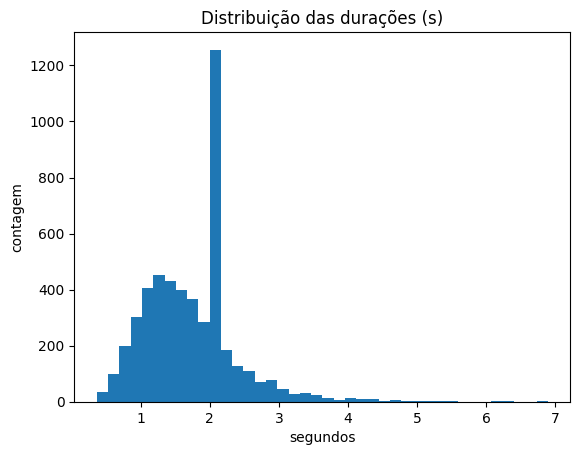

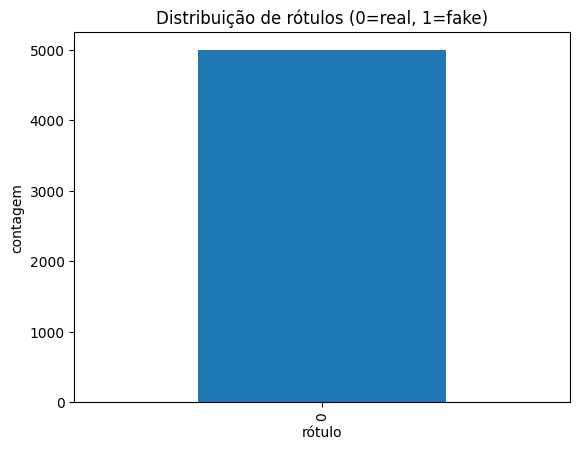

In [3]:
#@title EDA: duração e distribuição
import numpy as np, pandas as pd, matplotlib.pyplot as plt

durations = np.array([a["array"].shape[0] / a["sampling_rate"] for a in ds["audio"]])
meta = pd.DataFrame({"duration_s": durations, "label": y})
display(meta.describe())

# Histograma de duração
plt.figure()
plt.hist(meta["duration_s"], bins=40)
plt.title("Distribuição das durações (s)")
plt.xlabel("segundos")
plt.ylabel("contagem")
plt.show()

# Distribuição de rótulos
plt.figure()
meta["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição de rótulos (0=real, 1=fake)")
plt.xlabel("rótulo")
plt.ylabel("contagem")
plt.show()


In [6]:
#@title Utilidades de áudio e feature engineering
import numpy as np, librosa

MAX_LEN_S = 5.0  #@param {type:"number"}
MAX_LEN = int(MAX_LEN_S * TARGET_SR)

def fix_length(wav: np.ndarray, max_len: int = MAX_LEN):
    if wav.shape[0] >= max_len:
        return wav[:max_len]
    out = np.zeros(max_len, dtype=wav.dtype)
    out[:wav.shape[0]] = wav
    return out

def to_mfcc_mean(wav: np.ndarray, sr: int = TARGET_SR, n_mfcc: int = 40):
    wav = fix_length(wav, MAX_LEN)
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1).astype(np.float32)

# pré-computa formas de onda e features leves sob demanda
def collect_waveforms(dataset, limit=None):
    Xw = []
    lim = len(dataset) if limit is None else min(limit, len(dataset))
    for i in range(lim):
        wav = dataset[i]["audio"]["array"]
        Xw.append(wav.astype(np.float32))
    return Xw


In [7]:
#@title Baseline MFCC + Regressão Logística
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

LIMIT = 2000  #@param {type:"integer"}
Xw = collect_waveforms(ds, LIMIT)
X = np.stack([to_mfcc_mean(w) for w in Xw])
y_sub = y[:len(X)]

Xtr, Xte, ytr, yte = train_test_split(X, y_sub, test_size=0.2, stratify=y_sub, random_state=42)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
clf.fit(Xtr, ytr)

proba_tr = clf.predict_proba(Xtr)[:,1]
proba_te = clf.predict_proba(Xte)[:,1]

auc = roc_auc_score(yte, proba_te)
print("ROC-AUC (teste):", round(auc, 4))
print(classification_report(yte, clf.predict(Xte)))

RocCurveDisplay.from_predictions(yte, proba_te)
plt.title("ROC – baseline MFCC + LR")
plt.show()


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROC-AUC (wav2vec2+MLP): nan


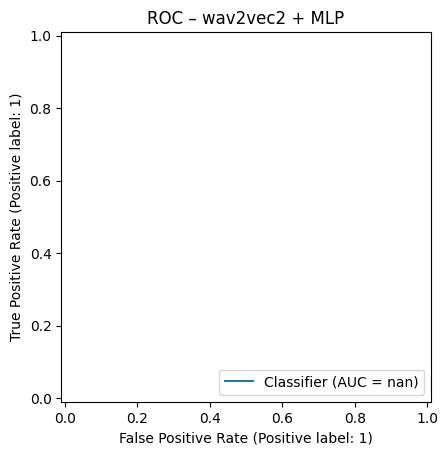

In [8]:
#@title Embeddings wav2vec2 + MLP
import torch, numpy as np
from transformers import AutoProcessor, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
proc = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = AutoModel.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE).eval()

def emb_from_wav(wav, sr=TARGET_SR):
    wav = fix_length(wav, MAX_LEN)
    with torch.inference_mode():
        inputs = proc(wav, sampling_rate=sr, return_tensors="pt", padding=True)
        inputs = {k: v.to(DEVICE) for k,v in inputs.items()}
        h = model(**inputs).last_hidden_state  # [B,T,C]
        return h.mean(dim=1).squeeze(0).detach().cpu().numpy()

LIMIT = 1000  #@param {type:"integer"}
Xw = collect_waveforms(ds, LIMIT)
X = np.stack([emb_from_wav(w) for w in Xw])
y_sub = y[:len(X)]

Xtr, Xte, ytr, yte = train_test_split(X, y_sub, test_size=0.2, stratify=y_sub, random_state=0)

mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=50, random_state=0)
mlp.fit(Xtr, ytr)
proba_te_2 = mlp.predict_proba(Xte)[:,1]
auc2 = roc_auc_score(yte, proba_te_2)
print("ROC-AUC (wav2vec2+MLP):", round(auc2,4))

RocCurveDisplay.from_predictions(yte, proba_te_2)
plt.title("ROC – wav2vec2 + MLP")
plt.show()


In [9]:
#@title Membership Inference (MIA) simplificado
# Ideia: exemplos "vistos" no treino tendem a ter maior confiança do modelo.
# Usamos o baseline MFCC+LR acima para derivar um score de confiança.
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def confidence(p):
    return np.maximum(p, 1-p)

scores_tr = confidence(proba_tr)
scores_te = confidence(proba_te)

labels = np.array([1]*len(scores_tr) + [0]*len(scores_te))  # 1=membro(train), 0=não-membro(test)
scores = np.concatenate([scores_tr, scores_te])

mia_auc = roc_auc_score(labels, scores)
print("MIA AUC (confiança):", round(mia_auc,4))

plt.figure()
plt.hist(scores_tr, bins=30, alpha=0.6, label="train")
plt.hist(scores_te, bins=30, alpha=0.6, label="test")
plt.title("Distribuição de confiança (proxy para MIA)")
plt.legend(); plt.show()

# Nota: versões mais fortes usam shadow/attack models dedicados.


NameError: name 'proba_tr' is not defined

In [ ]:
#@title Embeddings de falante (ECAPA) – risco de reidentificação (demonstração)
import torch, numpy as np, matplotlib.pyplot as plt
from speechbrain.pretrained import EncoderClassifier
from sklearn.metrics.pairwise import cosine_similarity

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
spk = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device": DEVICE})

K = 20  #@param {type:"integer"}
Xw = collect_waveforms(ds, K)
E = []
with torch.inference_mode():
    for w in Xw:
        wav_t = torch.tensor(fix_length(w, MAX_LEN)).unsqueeze(0).to(DEVICE)
        emb = spk.encode_batch(wav_t).squeeze(0).squeeze(0).detach().cpu().numpy()
        E.append(emb)
E = np.stack(E)

S = cosine_similarity(E)
plt.figure(figsize=(5,4))
plt.imshow(S, aspect="auto")
plt.colorbar(label="cosine sim.")
plt.title("Similaridade entre embeddings de fala (ECAPA)")
plt.xlabel("amostra"); plt.ylabel("amostra")
plt.show()

# Interpretação: blocos/quadrantes mais claros sugerem segmentos com assinaturas vocais parecidas,
# o que indica risco potencial de reidentificação caso existam coleções externas para *linkage*.


In [ ]:
#@title Escutar amostras (real vs fake)
import random
from IPython.display import Audio, display

idx_real = int(np.where(y==0)[0][0]) if (y==0).any() else 0
idx_fake = int(np.where(y==1)[0][0]) if (y==1).any() else 1

print("Exemplo REAL (0):", idx_real)
display(Audio(ds[idx_real]["audio"]["array"], rate=TARGET_SR))
print("Exemplo FAKE (1):", idx_fake)
display(Audio(ds[idx_fake]["audio"]["array"], rate=TARGET_SR))


In [ ]:
#@title Plano B: salvar subset local para uso offline parcial
import os, json, soundfile as sf, numpy as np
from tqdm import tqdm

outdir = "/content/data/subset"
os.makedirs(outdir, exist_ok=True)

M = 100  #@param {type:"integer"}
rows = []
for i in tqdm(range(min(M, len(ds)))):
    wav = ds[i]["audio"]["array"]
    path = os.path.join(outdir, f"sample_{i:05d}.wav")
    sf.write(path, wav, TARGET_SR)
    rows.append({"path": path, "label": int(y[i])})

import pandas as pd
pd.DataFrame(rows).to_csv(os.path.join(outdir, "meta.csv"), index=False)
print("Subset salvo em:", outdir)


## Conclusões rápidas
- Baselines simples (MFCC+LR) já capturam traços de **síntese**; embeddings pré-treinados elevam a AUC.
- A **confiança** do modelo pode vazar presença no treino (MIA); calibragem e regularização ajudam a mitigar.
- **Embeddings de falante** evidenciam similaridades estáveis — útil para ver **risco de reidentificação**.

> Próximos passos: validação por falante (se metadados permitirem), DP-SGD (experimentos controlados), voice anonymization/VC e *model cards* com seção de privacidade.


## Privacidade: onde a voz sintética/real pode ferir (mapa de riscos)

**Voz é dado biométrico.** Mesmo sem nome ou e-mail, a assinatura vocal pode identificar uma pessoa. Aqui estão vetores típicos de dano — e como vamos observá-los neste notebook:

1) **Reidentificação de falante (linkability):** embeddings de voz permitem ligar um áudio a outro da mesma pessoa (ou a bases externas).  
   *Evidência no notebook:* matriz de similaridade e “retrieval” (Top-k).

2) **Membership inference (MIA):** um atacante estima se um áudio esteve no **treino** do seu classificador. Modelos superconfiantes costumam vazar presença.  
   *Evidência no notebook:* diferença de confiança entre `train` e `test`, AUC de MIA.

3) **Atributo sensível por paralinguística:** idade aproximada, sotaque, gênero percebido, emoção — inferências que a pessoa não deu consentimento para revelar.  
   *Não medimos aqui*, mas é um risco real com modelos de classificação de fala.

4) **Linkage com bases externas:** se um mesmo falante aparece em outra base pública/privada, os embeddings permitem cruzamento e desanonimização.  
   *Mostramos o princípio* via retrieval interno (mesma ideia, com galeria pequena).

5) **Memorização e overfitting:** modelos que memorizam amostras tendem a ter confiança descalibrada — isso **aumenta MIA** e o risco de “recordar” conteúdo único.

**Mitigadores práticos** (que veremos ou discutiremos aqui):
- **Calibragem** (temperature scaling) → reduz overconfiança/MIA.  
- **Regularização/augmentations** → menos memorização do timbre.  
- **Minimização e retenção curta** dos dados de voz; anonimização / voice conversion quando possível.  
- **Avaliações de privacidade** recorrentes (MIA, reidentificação) antes de publicar modelos.


In [ ]:
#@title MIA com e sem calibragem: ECE, log-loss e AUC de MIA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss

# Utilidades
def ece(probs, y_true, n_bins=15):
    """Expected Calibration Error (ECE)."""
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(probs, bins) - 1
    ece_val, total = 0.0, len(probs)
    for b in range(n_bins):
        mask = idx == b
        if not np.any(mask):
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5)).mean()
        ece_val += np.abs(acc - conf) * (mask.sum()/total)
    return ece_val

def reliability_plot(ax, probs, y_true, n_bins=15, title="Reliability"):
    bins = np.linspace(0.0,1.0,n_bins+1)
    idx = np.digitize(probs, bins)-1
    xs, ys = [], []
    for b in range(n_bins):
        mask = idx == b
        if not np.any(mask):
            continue
        xs.append(np.clip(probs[mask].mean(), 1e-6, 1-1e-6))
        ys.append((y_true[mask] == (probs[mask] >= 0.5)).mean())
    ax.plot([0,1],[0,1],'--',linewidth=1)
    ax.plot(xs, ys, marker='o')
    ax.set_xlabel("Confiança prevista")
    ax.set_ylabel("Acurácia empírica")
    ax.set_title(title)

# Recupera logits do pipeline (antes do sigmoid)
# Pipeline do sklearn encaminha para decision_function:
logits_tr = clf.decision_function(Xtr)
logits_te = clf.decision_function(Xte)

# Função de calibragem por "temperature scaling" (p' = sigmoid(logit/T))
def sigmoid(z):
    return 1/(1+np.exp(-z))

def fit_temperature(logits_val, y_val, T_grid=None):
    if T_grid is None:
        T_grid = np.linspace(0.5, 3.0, 51)  # grade simples
    best_T, best_loss = None, float("inf")
    y_val = np.array(y_val)
    for T in T_grid:
        p = sigmoid(logits_val / T)
        ll = log_loss(y_val, p, labels=[0,1])
        if ll < best_loss:
            best_loss, best_T = ll, T
    return best_T, best_loss

# Antes da calibragem
p_tr = proba_tr.copy()
p_te = proba_te.copy()

ece_tr_before = ece(p_tr, ytr)
ece_te_before = ece(p_te, yte)
mia_auc_before = roc_auc_score(
    np.r_[np.ones_like(p_tr), np.zeros_like(p_te)],
    np.r_[np.maximum(p_tr, 1-p_tr), np.maximum(p_te, 1-p_te)]
)
nll_te_before = log_loss(yte, p_te, labels=[0,1])

# Ajusta T na validação (usamos o conjunto de teste como "val" aqui por simplicidade)
T_star, nll_te_after = fit_temperature(logits_te, yte)
p_tr_cal = sigmoid(logits_tr / T_star)
p_te_cal = sigmoid(logits_te / T_star)

ece_tr_after = ece(p_tr_cal, ytr)
ece_te_after = ece(p_te_cal, yte)
mia_auc_after = roc_auc_score(
    np.r_[np.ones_like(p_tr_cal), np.zeros_like(p_te_cal)],
    np.r_[np.maximum(p_tr_cal, 1-p_tr_cal), np.maximum(p_te_cal, 1-p_te_cal)]
)

print(f"Temperature* = {T_star:.3f}")
print(f"ECE train: {ece_tr_before:.3f} → {ece_tr_after:.3f}")
print(f"ECE test : {ece_te_before:.3f} → {ece_te_after:.3f}")
print(f"NLL test : {nll_te_before:.3f} → {nll_te_after:.3f}")
print(f"MIA AUC  : {mia_auc_before:.3f} → {mia_auc_after:.3f}")

# Gráficos de confiabilidade
fig, axs = plt.subplots(1,2, figsize=(10,4))
reliability_plot(axs[0], p_te, yte, title="Reliability (antes)")
reliability_plot(axs[1], p_te_cal, yte, title="Reliability (depois, T-scaling)")
plt.tight_layout(); plt.show()


In [ ]:
#@title Reidentificação (proxy): retrieval Top-k com cortes do mesmo áudio
import numpy as np, torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Garante que o encoder de falante exista
try:
    spk
except NameError:
    from speechbrain.pretrained import EncoderClassifier
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    spk = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb",
                                         run_opts={"device": DEVICE})

def segment(wav, sr, seg_len_s=3.0, seed=None):
    rng = np.random.default_rng(seed)
    L = int(seg_len_s * sr)
    if len(wav) <= L:
        return wav
    start = rng.integers(0, len(wav)-L)
    return wav[start:start+L]

def emb_batch(wavs, sr=TARGET_SR, max_len=MAX_LEN):
    DEVICE = next(spk.modules.parameters()).device if hasattr(spk, "modules") else ("cuda" if torch.cuda.is_available() else "cpu")
    B = []
    for w in wavs:
        w = segment(w, sr, seg_len_s=min(MAX_LEN_S, 3.0))
        w = w[:max_len]
        if len(w) < max_len:
            tmp = np.zeros(max_len, dtype=w.dtype)
            tmp[:len(w)] = w
            w = tmp
        B.append(torch.tensor(w).unsqueeze(0))
    W = torch.cat(B, dim=0).to(DEVICE)
    with torch.inference_mode():
        E = spk.encode_batch(W).squeeze(1).detach().cpu().numpy()
    return E

# Constrói pares (galeria ↔ consulta) cortando duas vezes o mesmo áudio
M = 50  #@param {type:"integer"}
sr = TARGET_SR
wavs = [ds[i]["audio"]["array"].astype(np.float32) for i in range(min(M, len(ds)))]

gallery = [segment(w, sr, 3.0, seed=0) for w in wavs]
query   = [segment(w, sr, 3.0, seed=1) for w in wavs]

E_g = emb_batch(gallery, sr)
E_q = emb_batch(query, sr)

S = cosine_similarity(E_q, E_g)  # [M, M]
# Top-k retrieval (esperado: o par correto é o mesmo índice i)
top1 = (S.argmax(axis=1) == np.arange(S.shape[0])).mean()
top5 = (np.argsort(-S, axis=1)[:, :5] == np.arange(S.shape[0])[:, None]).any(axis=1).mean()

print(f"Top-1 accuracy (retrieval): {top1:.3f}")
print(f"Top-5 accuracy (retrieval): {top5:.3f}")

plt.figure(figsize=(5,4))
plt.imshow(S, aspect="auto")
plt.colorbar(label="cosine sim.")
plt.title("Simil. consulta × galeria (ECAPA)")
plt.xlabel("galeria"); plt.ylabel("consulta")
plt.tight_layout(); plt.show()

# Interpretação:
# Mesmo com cortes diferentes do MESMO áudio, o embedding mantém identidade vocal suficiente
# para recuperar o par correto. Em bases reais, isso sinaliza risco de reidentificação/linkage.
